# 🍉时令蔬菜有哪些？针对国内农产品批发价的时间序列分析

## 摘要

又到了吃西瓜的季节。之所以在夏季吃西瓜，不仅仅因为其可以解暑，而且在夏天是西瓜的大量上市时期，价格还会比较便宜。在我们的食谱中，还有许多像西瓜这样的具有明显季节性的食材。这次的项目将通过分析农产品批发价的时间序列数据，发现具有强季节性的蔬菜，为在合适的季节吃合适的蔬菜提供参考。同时也对过去几年农产品的价格变化趋势进行了解。其中的主要发现包括：

- 价格具有强季节性的农产品主要是蔬菜和水果。例如菠菜、韭菜在春季，西瓜、冬瓜在夏季，巨峰葡萄在秋季，莲藕在冬季的价格会较低。
- 在过去两年里，约52%的农产品有明显的价格变化趋势。其中大部分为价格上升趋势，以水产品为代表。而猪肉和生姜是少有的有着价格下降趋势的产品。

不过，价格变化不仅受到农产品供给变化的影响，还会受到市场需求、运输存储、制度政策等变化的影响。因此如果要确认是否真的是时令蔬菜，还应结合农产品的实际培育周期来进行校验。

## 数据说明

数据来自中国农业农村部在过去两年（2020年6月到2022年5月）从全国批发市场采集的逐月农产品批发价格数据。数据中涉及到的农产品品种包含5种畜禽产品、5种水果、7种水产品以及28种蔬菜。

In [8]:
## 环境准备

In [9]:
# !pip install pandas==1.3.5 matplotlib==3.5.2 seaborn==0.11.2 -i https://pypi.mirrors.ustc.edu.cn/simple/ > /dev/null 2>&1

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cycler
import seaborn as sns

plt.style.use("seaborn-darkgrid")

colors = mpl.cm.Dark2(range(7))

mpl_config = {
    "font.family": "Microsoft YaHei",
    "figure.figsize": (16, 5),
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.titlepad":8,
    "axes.labelsize":12,
    'axes.prop_cycle':cycler(color=colors)
}


mpl.rcParams.update(mpl_config)

C:\Users\12527\AppData\Local\Temp\ipykernel_18752\55140732.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [23]:
DATA_DIR = "data"

data_path = os.path.join(
    DATA_DIR, "wholesale_price_of_agricultural_products.csv")

raw_df = pd.read_csv(data_path, encoding="utf-8-sig")
raw_df.head(2)


,year_month,product,price,category
0,202012,芹菜,3.76,蔬菜
1,202012,西红柿,4.56,蔬菜


## 数据预处理

In [12]:
# 为贴近常用的农产品标价单价，将原本的价格单位`元/公斤`转化为`元/斤`。（一公斤等于一千克，一斤等于500克）

df = raw_df.assign(
    year_month = raw_df["year_month"].astype("str")
).rename({"price":"price_1kg"},axis=1)

df = df.assign(
    year = df["year_month"].map(lambda x:int(x[:4])),
    month = df["year_month"].map(lambda x:int(x[-2:])),
    year_month = df["year_month"].map(lambda x:f"{x[:4]}-{x[-2:]}"),
    price_500g = df["price_1kg"]/2
)

df.head(10)

,year_month,product,price_1kg,category,year,month,price_500g
0,2020-12,芹菜,3.76,蔬菜,2020,12,1.880
1,2020-12,西红柿,4.56,蔬菜,2020,12,2.280
2,2020-12,豆角,7.90,蔬菜,2020,12,3.950
3,2020-12,白萝卜,1.93,蔬菜,2020,12,0.965
4,2020-12,茄子,4.97,蔬菜,2020,12,2.485
5,2020-12,胡萝卜,2.45,蔬菜,2020,12,1.225
6,2020-12,黄瓜,4.40,蔬菜,2020,12,2.200
7,2020-12,莴笋,3.16,蔬菜,2020,12,1.580
8,2020-12,青椒,6.15,蔬菜,2020,12,3.075
9,2020-12,菜花,3.86,蔬菜,2020,12,1.930


In [13]:
def get_season(month):
    """将月份映射到季度上"""
    if month in (12,1,2):
        return 0
    elif month in (3,4,5):
        return 1
    elif month in (6,7,8):
        return 2
    elif month in (9,10,11):
        return 3

In [14]:
def get_title(products,category):
    if category is not None:
        target_name = f"各种{category}"
    else:
        max_target_show = 3
        target_name = "、".join(products[:max_target_show])
        if len(products) > max_target_show:
            target_name += "等"
    title = f"{target_name}的价格历史变化（2020年6月 - 2022年5月）"
    return title

In [15]:
from collections.abc import Iterable

UNIQUE_YEAR_MONTH = sorted(set(df["year_month"].values))

def plot_ts(products=None, category=None, ax=None, fig=None):
    """绘制部分产品的价格历史变化图

    Parameters
    ----------
    products : list or str, optional
        产品名称或产品名称的列表
    category : str, optional
        品类名称
    ax: mpl.axes.Axes, optional
        如果为空，则会重新创建图层
    fig: matplotlib.Figure, optional
        如果为空，则会重新创建画布
    """

    if isinstance(products, Iterable):
        _products = products
    elif isinstance(products, str):
        _products = [products]
    elif isinstance(category, str):
        _products = list(
            set(df.query(f"category == '{category}'")["product"].values))
    else:
        raise Exception("未正确设置products或category")

    if ((ax is None) or (fig is None)):
        _fig, _ax = plt.subplots(figsize=(16, 10))
    else:
        _fig, _ax = fig, ax

    # 绘制价格历史变化折线图

    y_max = 0
    for product in _products:
        cdf = df.query(f"product == '{product}'").sort_values("year_month")
        y = cdf["price_500g"].values
        y_max = max(max(y), y_max)
        _ax.plot(UNIQUE_YEAR_MONTH, y, "-o", label=product)
    _ax.set_ylim(0,)
    tick_labels = [i[-5:] for i in UNIQUE_YEAR_MONTH]
    _ax.set_xticks(range(len(UNIQUE_YEAR_MONTH)), tick_labels)

    title = get_title(products, category)
    _ax.set_title(title, pad=20)
    _ax.set_ylabel("批发价（元/斤）", labelpad=30)
    _ax.set_xlabel("年月", labelpad=10)

    # 使用imshow绘制四季背景色

    data = [[get_season(int(x[-2:])) for x in UNIQUE_YEAR_MONTH]]

    cmap = mpl.colors.ListedColormap(
        ['LightBlue', "YellowGreen", "Tomato", "SandyBrown"])

    ims = _ax.imshow(
        data,
        extent=(0, len(UNIQUE_YEAR_MONTH), 0, y_max*1.1),
        cmap=cmap,
        alpha=0.8)

    # 调整ticks的位置，使得label可以对应到每个颜色的中央
    colorbar_ticks = [0.4, 1.15, 1.85, 2.6]
    colorbar_labels = ["冬", "春", "夏", "秋"]
    colorbar = _fig.colorbar(ims,
                             ax=_ax,
                             label="四季",
                             ticks=colorbar_ticks,
                             orientation='horizontal',
                             shrink=0.2)
    colorbar.set_ticklabels(colorbar_labels)
    _ax.legend(loc='upper right', bbox_to_anchor=(0.6, 0.5, 0.5, 0.5))
    _ax.set_aspect("auto")


# plot_ts(category='水产品')

### 畜禽产品

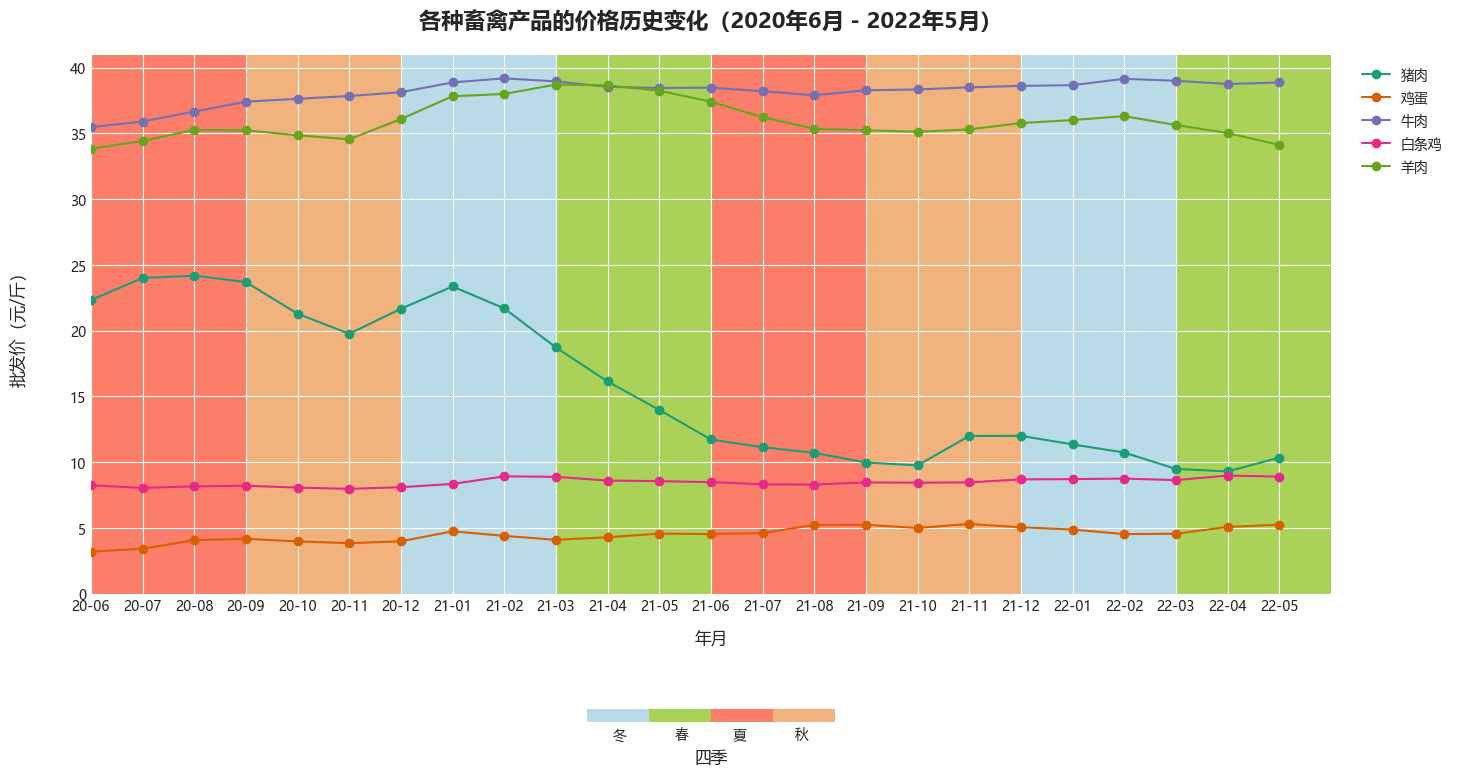

In [16]:
plot_ts(category="畜禽产品")

从畜禽产品的价格历史变化可以看出：

- 猪肉的价格有一个明显的下降过程。主要下降的时间段发生在2021年2月到2021年10月，从20元/斤以上的价格下降到10元/斤左右。
- 除猪肉之外的其他畜禽产品价格则较为稳定。

### 水产品

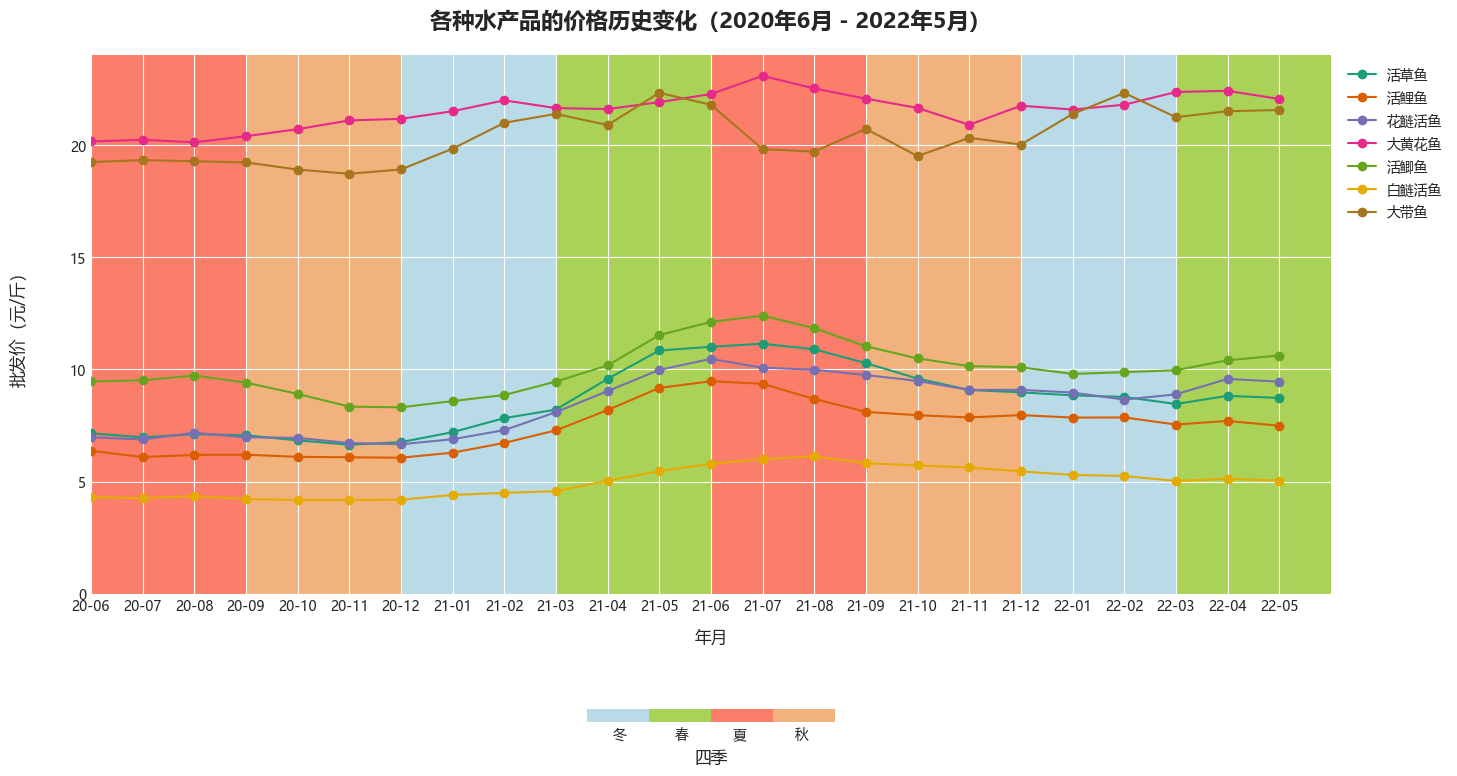

In [17]:
plot_ts(category="水产品")

从水产品的价格历史变化可以看出：

- 水产品的价格整体呈小幅上升的趋势。
- 鲫鱼、鲤鱼等淡水鱼在2021年的春季出现明显的价格上涨，并在当年夏秋季逐渐回落。

当时有一份2021年5月份关于淡水鱼价格上升的[报道](http://henan.china.com.cn/finance/2021-05/25/content_41572802.htm)，其中提到了一些可能的原因：

- 以往淡水鱼价格较低，导致淡水鱼养殖面积减少
- 春节期间的供应减少了当前的供给
- 气温较高时活鱼在运输中的损耗大
- 夏季为淡水鱼的需求旺季

### 水果

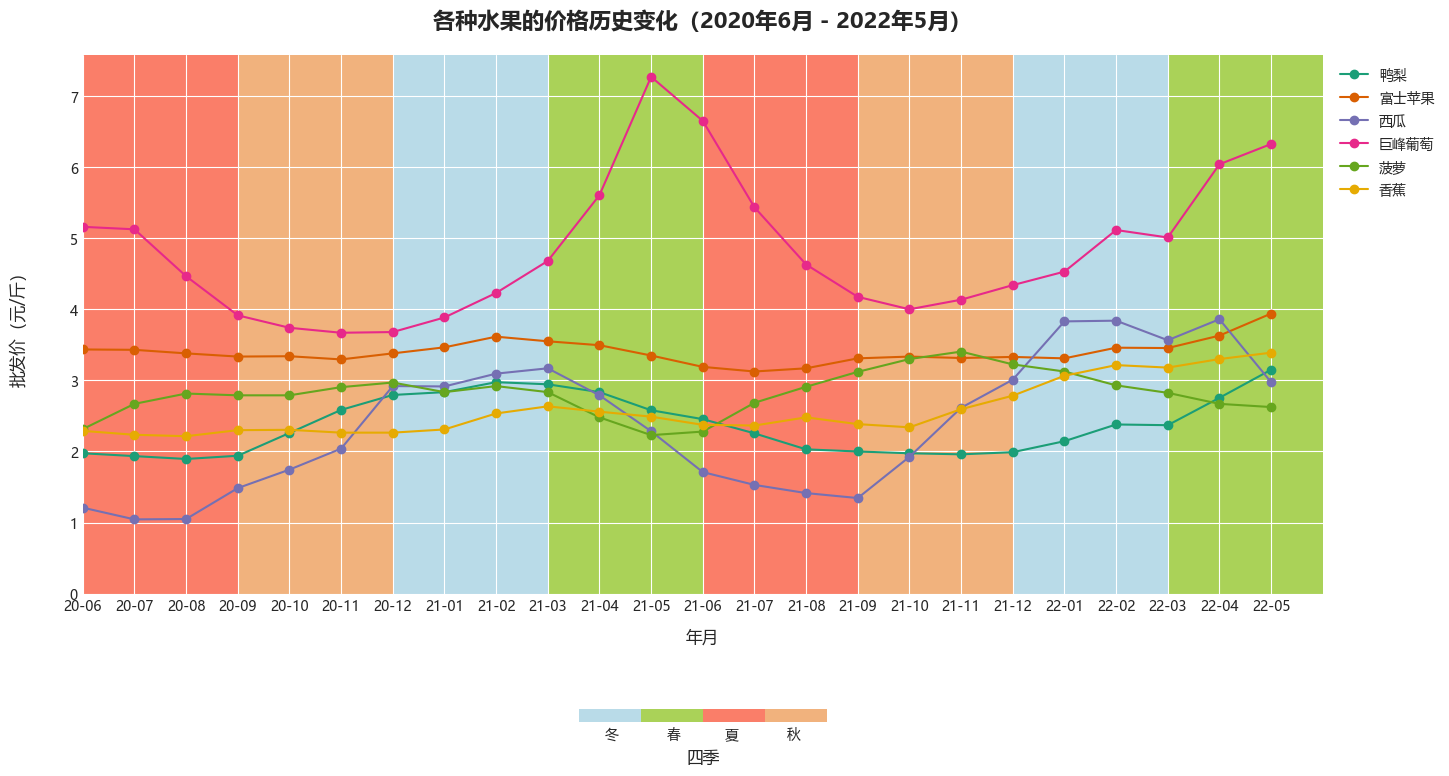

In [18]:
plot_ts(category="水果")

水果有着更加明显的季节性

- 巨峰葡萄在秋季价格较低，而在春末夏初达到价格顶峰。
- 人人都喜欢的西瓜在夏季和初秋的价格会比较低，因此即使是遇到了秋老虎，我们仍然可以买到便宜的西瓜。

### 蔬菜

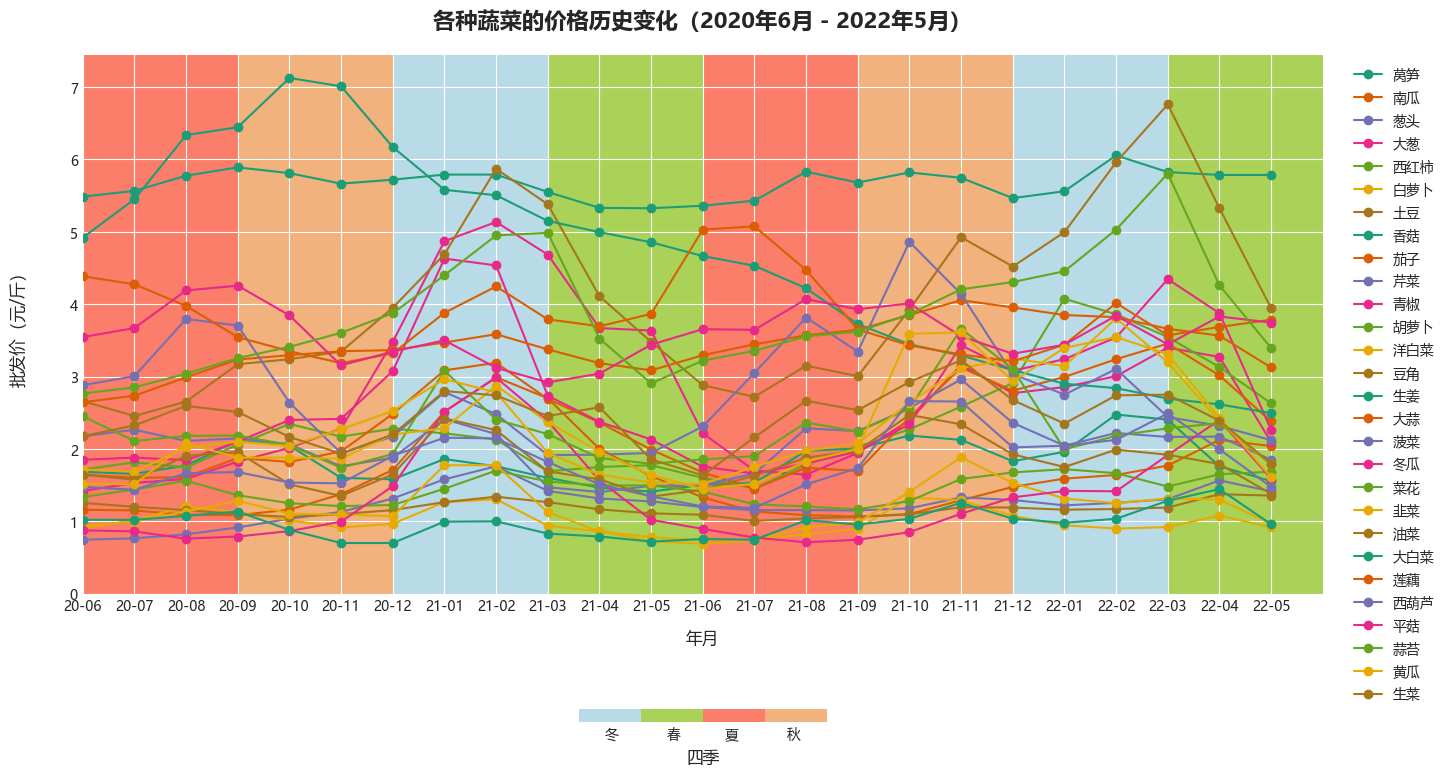

In [19]:
plot_ts(category="蔬菜")

蔬菜种类众多，全部展示出来的效果比较差。后面会用其他方式分析其价格变化的规律。

## 农产品批发价的历史波动幅度

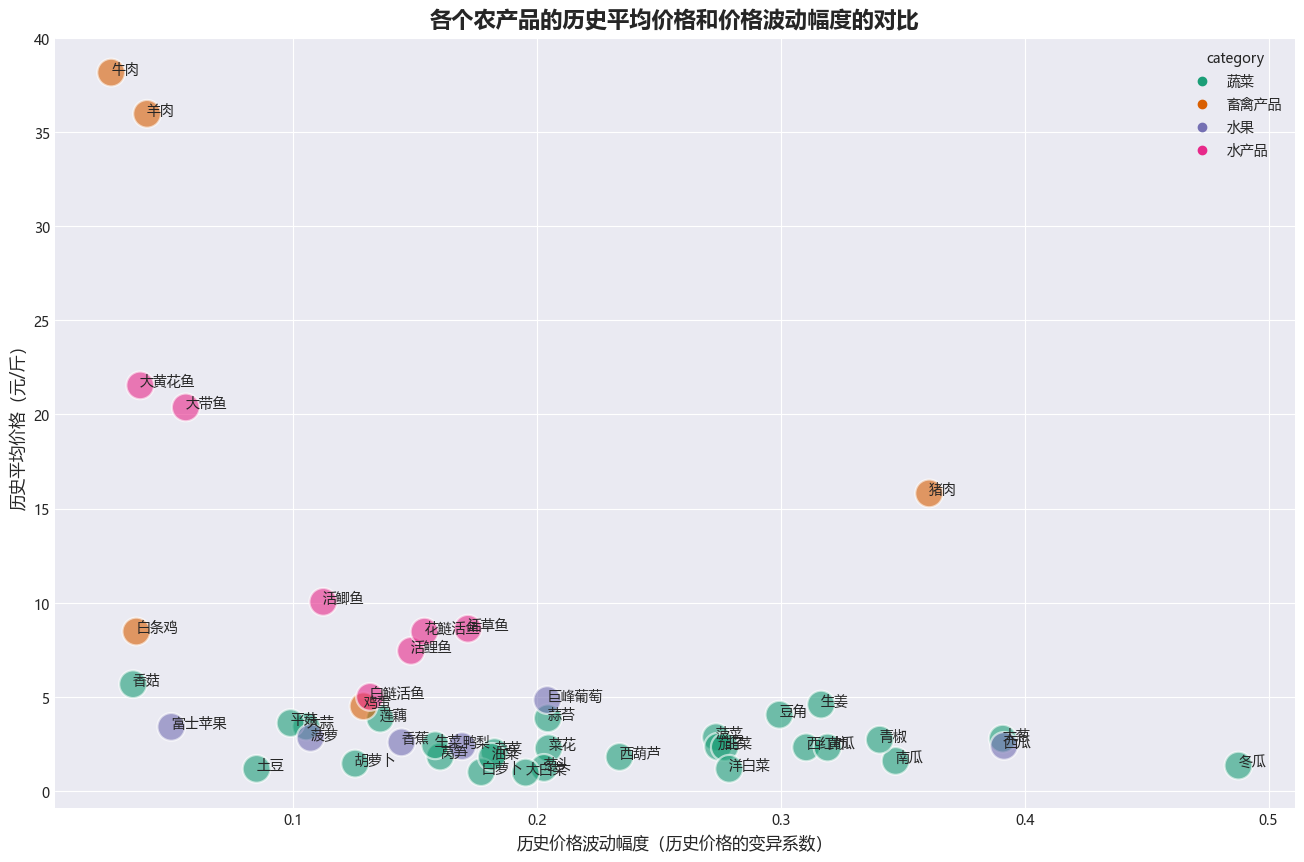

In [20]:
# 基于农产品和品类的数据汇总
product_gdf = df.groupby(["product", "category"]).agg(
    price_500g_std=("price_500g", "std"),
    price_500g_max=("price_500g", "max"),
    price_500g_min=("price_500g", "min"),
    price_500g_mean=("price_500g", "mean")
)

# 计算价格的变异系数（coefficient of variation）
product_gdf = product_gdf.assign(
    price_500g_varc=product_gdf["price_500g_std"] /
    product_gdf["price_500g_mean"]
)

def plot_price_varc_chart():
    _, ax = plt.subplots(figsize=(16, 10))

    sns.scatterplot(data=product_gdf.reset_index().sort_values("category",ascending=False), x="price_500g_varc", y="price_500g_mean",
                    hue="category", alpha=0.6, ax=ax, s=400)
    for product, i, j in product_gdf.reset_index()[["product", "price_500g_varc", "price_500g_mean"]].values:
        ax.text(i, j, product)

    ax.set_title("各个农产品的历史平均价格和价格波动幅度的对比")
    ax.set_xlabel("历史价格波动幅度（历史价格的变异系数）")
    ax.set_ylabel("历史平均价格（元/斤）")


plot_price_varc_chart()


上面对比了各个农产品的历史平均价格和历史价格的波动幅度：

- 波动幅度较大的农产品以蔬菜为主。且在蔬菜里面，瓜果类的价格变动会更高，根茎类/菇类的蔬菜价格波动较小，叶菜类的价格波动居中。这可能和不同蔬菜的培育和存储特点有关。
- 猪肉的位置非常显眼，其在平均价格较高的情况下仍然有较大的价格波动幅度。其价格变化也确实在过去几年引起了人们的普遍关注。
- 西瓜和巨峰葡萄是水果品类中价格波动最大的两个产品。这可能体现了其较强的季节性。
- 价格较高的牛肉、羊肉等的价格波动幅度较小。

PS：

$$

历史价格波动幅度 = 历史价格的变异系数 = \frac{历史价格的标准差}{历史价格的平均值}

$$

## 使用多元回归计算农产品价格的趋势和季节性

### 如何计算季节性

下面使用多元回归的方法来分析价格的季节性。以西瓜为例，其步骤为：

1. 选取西瓜的历史批发价数据。本数据集中一共有24个月的数据。
2. 将每个月的价格视为回归的目标变量。
3. 将24个月按照顺序赋予从1到24的序号，作为趋势的特征变量。
4. 对月份进行One-Hot编码，得到从1月到12月的12个特征变量。每条西瓜的价格记录都会在其中某个月的特征变量中标注为1，其他月份则为0。
5. 基于上述特征变量，针对目标变量价格构建多元回归模型
6. 以回归模型针对趋势特征变量的系数代表价格变化趋势，以各个月份特征变量的系数代表该月对价格的影响，即季节性影响。

In [21]:
import statsmodels.api as sm

def fit_regression_model(product):

    sdf = df.query(f"product == '{product}'")
    sdf = sdf.sort_values("year_month").assign(
        ts_rank = range(1,sdf.shape[0]+1),
        constant = 1,
        month = sdf["month"].map(lambda x:f"month-{x:02}")
    )
    sdf = pd.concat([sdf,pd.get_dummies(sdf["month"])],axis=1)

    # 包含1个序列，12个月和一个常数列，所以是最后14列
    feature_names = sdf.columns[-14:]
    target_name = "price_500g"
    X = sdf[feature_names].values
    y = sdf[target_name]

    model = sm.OLS(y, sdf[feature_names])
    fit_result = model.fit()
    return model,fit_result,X,y

product = '西瓜'
model,fit_result,X,y = fit_regression_model(product)

ModuleNotFoundError: No module named 'statsmodels'

下面是以西瓜为例的拟合结果，可以看到各个特征变量的参数及其P值的结果

In [ ]:
fit_result.summary()

通过上述方法，我们可以从价格的时间序列中分离出价格的趋势和季节性。分离后的效果如下图所示。

In [ ]:
def plot_regression_result(model, fit_result, X, y):
    """
    绘制回归拟合后的图表，包括
    - 估计值和实际值的对比
    - 趋势
    - 季节性
    """
    year_month = [x[-5:] for x in UNIQUE_YEAR_MONTH]

    fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,figsize=(16,10))

    params = fit_result.params
    
    ax1.plot(year_month,model.predict(params, X),label="估计值")
    ax1.plot(year_month,y,label="实际值")
    ax1.legend()
    ax1.set_ylim(0,)
    ax1.set_title("估计值和实际值对比")

    x = range(1,len(year_month)+1)

    trend = lambda x:params["ts_rank"] * x + params["constant"]

    trend_value = [trend(i) for  i in x]
    ax2.plot(year_month, trend_value)
    ax2.set_ylim(min(0,min(trend_value) * 1.5),max(trend_value) *1.5)
    ax2.set_title("趋势")

    month_coef = params.drop(["ts_rank","constant"])
    month_coef_values = month_coef.values.tolist()
    ax3.plot(month_coef.index.values.tolist(),month_coef_values )
    ax3.set_ylim(min(0,min(month_coef_values) *1.5),max(month_coef_values) *1.5)
    ax3.set_title("季节性")
    fig.suptitle(f"针对{product}的时间序列分析", fontsize=20, fontweight="bold")
    fig.tight_layout()
    
    

def plot_product_regression(product):
    model,fit_result,X,y = fit_regression_model(product)
    plot_regression_result(model,fit_result,X,y)

plot_product_regression(product)

### 计算所有农产品的季节性信息

In [ ]:
TEST_ALPHA_VALUE = 0.05

def get_season_info(fit_result,):
    
    pvalue_check = fit_result.pvalues < TEST_ALPHA_VALUE
    params = fit_result.params

    x = range(1,len(UNIQUE_YEAR_MONTH)+1)

    trend = lambda x:params["ts_rank"] * x + params["constant"]
    trend_value = [trend(i) for  i in x]
    
    season_params = params.drop(["ts_rank","constant"])
    return {
        "is_trend_significant":pvalue_check["ts_rank"],
        "trend_std":np.round(np.std(trend_value),4),
        "trend_slope":np.round(params["ts_rank"],4),
        "season_significant_rate":np.round(pvalue_check.drop(["ts_rank","constant"]).mean(),4),
        "season_std":np.round(season_params.std(),4),
        "season_values":np.round(season_params.values,4),
        "season_pvalues":np.round(fit_result.pvalues.drop(["ts_rank","constant"]).values,4)

    }

# get_season_info(fit_result)

In [ ]:
def get_all_prdocut_season_info():
    products = list(set(df["product"].values))
    season_info_collect  = []
    for product in products:
        model,fit_result,X,y = fit_regression_model(product)
        season_info = get_season_info(fit_result)
        season_info.update(
            {
                "product":product
            }
        )
        season_info_collect.append(season_info)
    season_df = pd.DataFrame(season_info_collect)
    return season_df

season_df = get_all_prdocut_season_info()
# season_df.head()

In [ ]:
season_mdf = pd.merge(season_df,product_gdf.reset_index(),on="product")
season_mdf = season_mdf.assign(
    season_varc = season_mdf["season_std"]/season_mdf["price_500g_mean"],
    trend_varc = season_mdf["trend_std"]/season_mdf["price_500g_mean"],
    season_varc_percent = season_mdf["season_std"]/season_mdf["price_500g_std"],
    trend_varc_percent = season_mdf["trend_std"]/season_mdf["price_500g_std"],
)

# season_mdf.sort_values("season_varc",ascending=False).head(1)

### 哪些农产品的季节性更强？

In [ ]:
def plot_seasonal_comapre():
    fig,ax=plt.subplots(figsize=(16,10))
    x_col = "season_varc"
    y_col ="price_500g_mean"
    size_col = "season_significant_rate"

    x_col = "season_significant_rate"
    y_col = "season_varc"
    size_col = "season_varc_percent"

    sns.scatterplot(data=season_mdf.sort_values("category",ascending=False),x=x_col,y=y_col,
        size=size_col,hue="category",ax=ax,sizes=(200,400),alpha=0.7)
    ax.set_xlabel("季节性的统计意义显著性程度")
    ax.set_xlim(-0.1,1.1)
    ax.set_ylabel("季节性对于价格的实际影响程度")
    ax.set_ylim(-0.1,)
    for i,j,product in season_mdf[[x_col,y_col,"product"]].values:
        ax.text(i,j,product)
    ax.set_title("不同农产品的季节性程度对比")
    ax.plot([0.2,0.2],[-0.1,0.5],"--",color=colors[-1])
    ax.plot([-0.1,1.1],[0.1,0.1],"--",color=colors[-1])

    ax.text(0.6,0.3,"①",fontdict={"size":20,"color":colors[-1]})
    ax.text(0.0,0.3,"②",fontdict={"size":20,"color":colors[-1]})
    ax.text(0.0,0.0,"③",fontdict={"size":20,"color":colors[-1]})
    ax.text(0.6,0.0,"④",fontdict={"size":20,"color":colors[-1]})
plot_seasonal_comapre()

上图的横坐标是农产品的季节性在统计意义上的显著性程度，纵坐标是季节性对农产品价格的实际影响程度。二者的数值越高，则代表农产品的季节性越强烈。

基于这两个数值，分别以0.2和0.1作为阈值，可以将农产品划分为四组。

- 第1组是我们最感兴趣的，其既有统计意义上显著性，在实际意义上也大幅影响价格波动。这一组以蔬菜和水果为主。
- 唯一的例外是猪肉。虽然猪肉有一定的季节性，但在过去几年，由于其降价趋势的影响，其季节性体现得不明显。
- 第4组的农产品虽然有统计意义上显著的季节性，但实际对价格影响较小，在实际生活中往往可以忽略不记。

PS：

$$
季节性在统计意义上的显著性程度 = \frac{通过显著性检验的月份}{12}
$$

$$

季节性对于价格的实际影响程度 = \frac{季节性波动的标准差}{价格的平均值}

$$

In [ ]:
product="豆角"
# product="西瓜"
plot_product_regression(product)

## 时令蔬菜有哪些？

In [ ]:
def plot_seasonal_heatmap(min_season_significant_rate=0.2, min_season_varc=0.1,season_varc_percent=0.4):
    query = f"season_significant_rate > {min_season_significant_rate} and season_varc > {min_season_varc} and season_varc_percent > {season_varc_percent}"
    season_sdf = season_mdf.query(query)
    n_product = season_sdf.shape[0]
    season_sdf = season_sdf[["product", "season_values"]].explode(
        "season_values")
    season_sdf = season_sdf.assign(
        year_month=list(range(1, 13)) * n_product,
        season_value=season_sdf["season_values"].map(float)
    )

    season_table = season_sdf.pivot("product", "year_month", "season_value")

    fig, ax = plt.subplots(figsize=(16, 6))
    sns.heatmap(season_table,cmap=mpl.cm.RdYlGn_r,
                norm=mpl.colors.Normalize(-2, 2), annot=True, fmt=".02f", ax=ax)
    ax.set_xlabel("月份")
    ax.set_ylabel("")
    ax.set_title("时令蔬菜的季节性价格变化热力图",pad=20)

plot_seasonal_heatmap(min_season_significant_rate=0.2, min_season_varc=0.1,season_varc_percent=0.4)


季节性价格热力图中，正数代表价格在当季的提升趋势，负数代表价格的下降趋势。

从整体来看，在春末和夏季有许多蔬菜产品会进入价格较便宜的时期。

如果根据月份来划分，并认为价格低的原因主要是蔬菜产量提升导致，则推导出各个时间的时令蔬菜有：

- 3月份-5月份：菠菜
- 4月份-7月份：韭菜
- 5月份-7月份：蒜苔
- 5月份-9月份：豆角、青椒
- 6月份-10月份：西瓜、茄子、大葱、南瓜、冬瓜
- 8月份-9月份：鸭梨
- 9月份-1月份：巨峰葡萄
- 11月份-12月份：莲藕

## 哪些农产品的价格有明显的涨跌？

In [ ]:
def plot_trend_chart():
    trend_significant_count_df = season_mdf.groupby("is_trend_significant").agg(count=("product","count"))
    trend_product_df = season_mdf.query("is_trend_significant == True")

    x_col = "trend_slope"
    y_col = "trend_varc"
    fig, [ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(16, 5))
    trend_significant_count_df.rename({True:"是",False:"否"}).plot.pie(ax=ax1,y="count",autopct='%1.1f%%',startangle=90)
    ax1.set_title("农产品是否有显著的价格变化趋势")
    ax1.set_ylabel("是否有显著价格变化趋势")
    
    sns.scatterplot(
        data=trend_product_df.sort_values("category", ascending=False),
        x=x_col,
        y=y_col,
        hue="category",
        ax=ax2,
        alpha=0.7,
        s=200
    )
    for i, j, product in season_mdf[[x_col, y_col, "product"]].values:
        if np.abs(i) > 0.05 or j > 0.1:
            ax2.text(i, j, product)
    ax2.set_title("有显著趋势的农产品的价格变化趋势")
    ax2.set_xlabel("价格的逐月变化率（元/斤月）")
    ax2.set_ylabel("趋势对于价格的实际影响程度")
    fig.tight_layout()


plot_trend_chart()


- 约有52%的农产品有显著的价格变化趋势。而在有显著的价格变化趋势的产品中，大部分农产品的价格呈现上升趋势。其中淡水鱼的价格上升最高。
- 大家都喜欢的西瓜也有一定的上升趋势。家庭料理中常见的黄瓜和西红柿也有明显的上限趋势。
- 在价格下降趋势的农产品中，除了我们熟知的猪肉之外，生姜也有着显著的下降趋势。其价格历史变化可以参考下图。

In [ ]:
plot_ts(products=["生姜","西红柿","西瓜"])

从中可以看到，生姜的批发价格在2020年10月达到顶峰之后就一直逐月下降。参考相关的[报道](http://finance.people.com.cn/n1/2021/1227/c1004-32317588.html)，生姜价格下降的主要原因是之前生姜价格持续上升，吸引了产量提升。但随后由于产量过高而发生供过于求，从而导致价格下降。



## 结语

谢谢阅览。如有问题欢迎沟通交流！